In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
import gc
from catboost import CatBoostRegressor
import seaborn as sns

In [27]:
def preprocess_train(seg_id, train):
    d = {'sma_10' : [0],
         'ewma_10' : [0],
         'ave' : [0],
         'std' : [0],
         'max' : [0],
         'min' : [0],
         'time_to_failure' : [0]}
    result = pd.DataFrame(d, dtype=np.float64)
    
    x = train["acoustic_data"].values
    
    train["sma_3"] = train["acoustic_data"].rolling(window = 3).mean()
    train['ewma_3'] = pd.Series.ewm(train["acoustic_data"], span=3).mean()
    train["sma_5"] = train["acoustic_data"].rolling(window = 5).mean()
    train['ewma_5'] = pd.Series.ewm(train["acoustic_data"], span=5).mean()
    train["sma_10"] = train["acoustic_data"].rolling(window = 10).mean()
    train['ewma_10'] = pd.Series.ewm(train["acoustic_data"], span=10).mean()
    train["sma_50"] = train["acoustic_data"].rolling(window = 50).mean()
    train['ewma_50'] = pd.Series.ewm(train["acoustic_data"], span=50).mean()
    train["sma_100"] = train["acoustic_data"].rolling(window = 100).mean()
    train['ewma_100'] = pd.Series.ewm(train["acoustic_data"], span=100).mean()
    
    result['time_to_failure'] = train["time_to_failure"].values[-1]
    result["seg_id"] = seg_id
    result["ewma_3"] = train["ewma_3"].mean()
    result["sma_3"] = train["sma_3"].mean()
    result["ewma_5"] = train["ewma_5"].mean()
    result["sma_5"] = train["sma_5"].mean()
    result["ewma_10"] = train["ewma_10"].mean()
    result["sma_10"] = train["sma_10"].mean()
    result["ewma_50"] = train["ewma_50"].mean()
    result["sma_50"] = train["sma_50"].mean()
    result["ewma_100"] = train["ewma_100"].mean()
    result["sma_100"] = train["sma_100"].mean()
    result['ave'] = x.mean()
    result['std'] = x.std()
    result['max'] = x.max()
    result['min'] = x.min()
    result['q01'] = np.quantile(x,0.01)
    result['q05'] = np.quantile(x,0.05)
    result['q95'] = np.quantile(x,0.95)
    result['q99'] = np.quantile(x,0.99)
    

    return result

In [28]:
frames = []
rows = 150_000
segments = 1
#train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

for df in pd.read_csv('../input/train.csv', chunksize=rows, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64}):
    _ = preprocess_train(segments, df)
    frames.append(_)
    segments += 1

X_train = pd.concat(frames)
X_train = X_train.set_index("seg_id")

In [29]:
X_train.head()

,sma_10,ewma_10,ave,std,max,min,time_to_failure,ewma_3,sma_3,ewma_5,sma_5,ewma_50,sma_50,ewma_100,sma_100,q01,q05,q95,q99
seg_id,,,,,,,,,,,,,,,,,,,
1,4.884088378635989,4.884241616265863,4.884113333333334,5.101089126891323,104,-98,1.4307971859,4.884167462435380,4.884107343653485,4.884201080817154,4.884095575881966,4.884270544770727,4.883969296636922,4.884335546276895,4.883863549942990,-8.0,-2.0,11.0,18.0
2,4.725731543892671,4.725763269986679,4.725766666666667,6.588801819164257,181,-154,1.3914988931,4.725763863125676,4.725756343417870,4.725760922746515,4.725730019467171,4.725809832481752,4.725729338250502,4.725842751947517,4.725623311385454,-11.0,-2.0,12.0,21.0
3,4.906229040409174,4.906390489500286,4.906393333333333,6.967373808828945,140,-106,1.3531960947,4.906395764152028,4.906394307479615,4.906392510202864,4.906374836662358,4.906429776004419,4.906072250268403,4.906416869434004,4.906088151513369,-15.0,-3.0,13.0,26.0
4,4.902290804114878,4.902126943248564,4.902240000000000,6.922282112791032,197,-199,1.3137978019,4.902213081352357,4.902254252278854,4.902180699534021,4.902297394597307,4.902043049787403,4.902059206007244,4.902052266336941,4.901946217837145,-12.0,-2.0,12.0,22.0
5,4.908727857004753,4.908785382625916,4.908720000000000,7.301085852684289,145,-126,1.2743995091,4.908729341458675,4.908658782117159,4.908744462593931,4.908658897570609,4.908880179258194,4.908957859567479,4.908872987383111,4.909174788693883,-15.0,-2.0,12.0,26.0


In [30]:
X_train.shape

(4195, 19)

In [32]:
params = {'num_leaves': 54,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 3,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 1.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'num_iterations' : 5000}

In [33]:
train_features = list()
TARGET = 'time_to_failure'
train_features = [f for f in X_train.columns if f != TARGET]

In [34]:
def sma (x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    temp = (cumsum[N:] - cumsum[:-N]) / float(N)
    result = np.zeros(len(x) - len(temp))
    result = np.concatenate((result, temp))
    #result = np.reshape(result, (len(result),1))
    return result

In [35]:
def preprocess(seg_id):
    d = {'sma_10' : [0],
         'ewma_10' : [0],
         'ave' : [0],
         'std' : [0],
         'max' : [0],
         'min' : [0]}
    test = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = test["acoustic_data"].values
    
    test["sma_3"] = test["acoustic_data"].rolling(window = 3).mean()
    test['ewma_3'] = pd.Series.ewm(test["acoustic_data"], span=3).mean()
    test["sma_5"] = test["acoustic_data"].rolling(window = 5).mean()
    test['ewma_5'] = pd.Series.ewm(test["acoustic_data"], span=5).mean()
    test["sma_10"] = test["acoustic_data"].rolling(window = 10).mean()
    test['ewma_10'] = pd.Series.ewm(test["acoustic_data"], span=10).mean()
    test["sma_50"] = test["acoustic_data"].rolling(window = 50).mean()
    test['ewma_50'] = pd.Series.ewm(test["acoustic_data"], span=50).mean()
    test["sma_100"] = test["acoustic_data"].rolling(window = 100).mean()
    test['ewma_100'] = pd.Series.ewm(test["acoustic_data"], span=100).mean()
    
    
    result = pd.DataFrame(d, dtype=np.float64)
    result["seg_id"] = seg_id
    result["sma_3"] = test["sma_3"].mean()
    result["ewma_3"] = test["ewma_3"].mean()
    result["sma_5"] = test["sma_5"].mean()
    result["ewma_5"] = test["ewma_5"].mean()
    result["sma_10"] = test["sma_10"].mean()
    result["ewma_10"] = test["ewma_10"].mean()
    result["sma_50"] = test["sma_50"].mean()
    result["ewma_50"] = test["ewma_50"].mean()
    result["sma_100"] = test["sma_100"].mean()
    result["ewma_100"] = test["ewma_100"].mean()
    result['ave'] = x.mean()
    result['std'] = x.std()
    result['max'] = x.max()
    result['min'] = x.min()
    result['q01'] = np.quantile(x,0.01)
    result['q05'] = np.quantile(x,0.05)
    result['q95'] = np.quantile(x,0.95)
    result['q99'] = np.quantile(x,0.99)
    
    return result
    

In [36]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
index = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)
frames = []
for seg_id in tqdm_notebook(index.index):
        _ = preprocess(seg_id)
        frames.append(_)
X_test = pd.concat(frames)
X_test = X_test.set_index("seg_id")

In [37]:
print(X_test.columns)
print(X_train.columns)

Index(['sma_10', 'ewma_10', 'ave', 'std', 'max', 'min', 'sma_3', 'ewma_3',
       'sma_5', 'ewma_5', 'sma_50', 'ewma_50', 'sma_100', 'ewma_100', 'q01',
       'q05', 'q95', 'q99'],
      dtype='object')
Index(['sma_10', 'ewma_10', 'ave', 'std', 'max', 'min', 'time_to_failure',
       'ewma_3', 'sma_3', 'ewma_5', 'sma_5', 'ewma_50', 'sma_50', 'ewma_100',
       'sma_100', 'q01', 'q05', 'q95', 'q99'],
      dtype='object')


In [38]:
print(X_test.head(10))
print(X_train.head(10))

                       sma_10            ewma_10  ...    q95   q99
seg_id                                            ...             
seg_00030f  4.491922848704198  4.491684314669440  ...   11.0  18.0
seg_0012b5  4.171169603509576  4.171217794543344  ...   11.0  20.0
seg_00184e  4.610255281983631  4.610334498190113  ...   11.0  20.0
seg_003339  4.531453887233320  4.531458551336902  ...   10.0  14.0
seg_0042cc  4.128355701342070  4.128344913932700  ...   10.0  19.0
seg_004314  4.148557580121454  4.148675666789552  ...   20.0  58.0
seg_004cd2  4.114267522717971  4.114147240723185  ...   10.0  15.0
seg_004ee5  4.328192358208076  4.328338470344701  ...   12.0  21.0
seg_004f1f  4.000696708469206  4.000707087581792  ...   11.0  20.0
seg_00648a  4.459079544772641  4.458783299047529  ...   12.0  26.0

[10 rows x 18 columns]
                   sma_10            ewma_10  ...    q95   q99
seg_id                                        ...             
1       4.884088378635989  4.884241616265863  

In [39]:
def train_model(X=X_train[train_features], X_test=X_test, y=X_train[TARGET], params=None, model_type='lgb', plot_feature_importance=False):
    
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            #print(X_test.head())
            #print(train.head())
            
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
           
        if model_type == 'svr':
            scaler = StandardScaler()
            scaled_train = scaler.fit_transform(X)
            scaled_valid = scaler.transform(X_valid)
            scaled_test = scaler.transform(X_test)
            
            
            svm1 = NuSVR(nu=0.6, C=1.3, kernel='rbf', gamma=10, tol=0.01)
            svm1.fit(scaled_train, y)
            
            y_pred_valid = svm1.predict(scaled_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = svm1.predict(scaled_test).reshape(-1,)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction
    
    else:
        return oof, prediction

Fold 0 started at Mon Jan 14 20:25:20 2019


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Fold 0. MAE: 1.9908.

Fold 1 started at Mon Jan 14 20:25:23 2019


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Fold 1. MAE: 1.8297.

Fold 2 started at Mon Jan 14 20:25:26 2019


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Fold 2. MAE: 1.9461.

Fold 3 started at Mon Jan 14 20:25:28 2019


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Fold 3. MAE: 1.8493.

Fold 4 started at Mon Jan 14 20:25:31 2019


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: DataConversionWarning: Data with input dtype int16, float64 were all converted to float64 by StandardScaler.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


Fold 4. MAE: 1.8841.

CV mean score: 1.3782, std: 0.0218.
Fold 0 started at Mon Jan 14 20:25:33 2019
Training until validation scores don't improve for 200 rounds.


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	training's l1: 1.95818	valid_1's l1: 2.2144
Early stopping, best iteration is:
[1044]	training's l1: 1.95219	valid_1's l1: 2.21368
Fold 1 started at Mon Jan 14 20:25:35 2019
Training until validation scores don't improve for 200 rounds.


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	training's l1: 2.00035	valid_1's l1: 2.05272
Early stopping, best iteration is:
[1347]	training's l1: 1.95502	valid_1's l1: 2.04938
Fold 2 started at Mon Jan 14 20:25:38 2019
Training until validation scores don't improve for 200 rounds.


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	training's l1: 1.96063	valid_1's l1: 2.20091
Early stopping, best iteration is:
[1278]	training's l1: 1.92465	valid_1's l1: 2.19673
Fold 3 started at Mon Jan 14 20:25:40 2019
Training until validation scores don't improve for 200 rounds.


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	training's l1: 2.00697	valid_1's l1: 2.0203
Early stopping, best iteration is:
[1269]	training's l1: 1.97031	valid_1's l1: 2.0187
Fold 4 started at Mon Jan 14 20:25:42 2019
Training until validation scores don't improve for 200 rounds.


/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1000]	training's l1: 1.9923	valid_1's l1: 2.07478
Early stopping, best iteration is:
[1035]	training's l1: 1.98704	valid_1's l1: 2.07414
CV mean score: 1.4525, std: 0.0273.


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


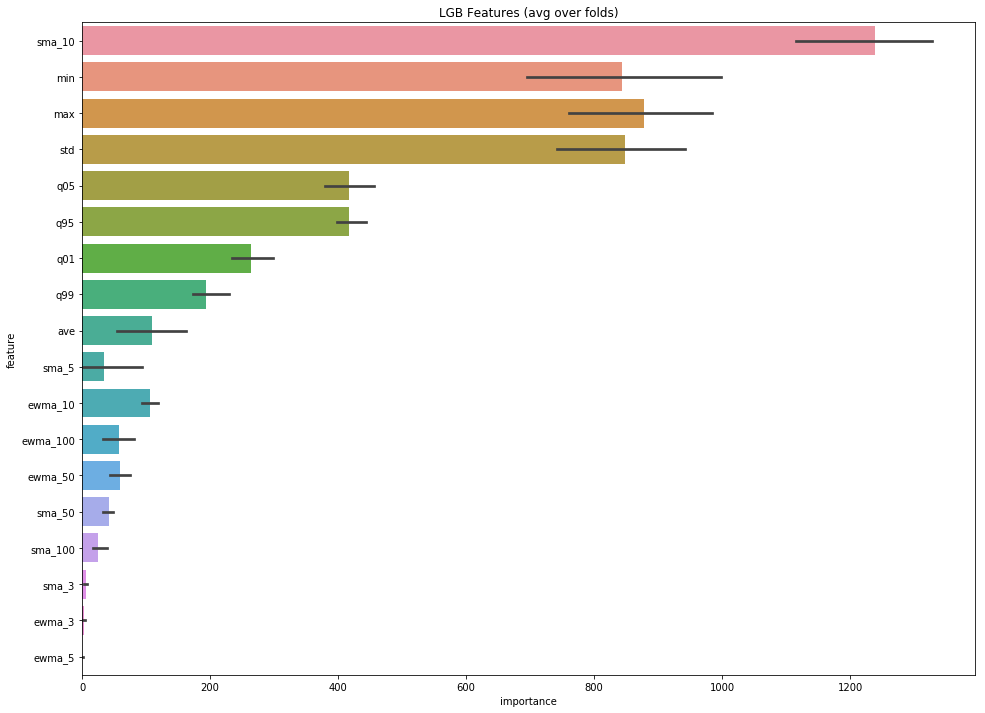

In [40]:
oof_lgb, prediction_svr, = train_model(params=None, model_type='svr')
oof_lgb, prediction_lgb, feature_importance = train_model(params=params, model_type='lgb', plot_feature_importance=True)

In [41]:
#print(submission.head())
print('LightGBM Predictions')
print(prediction_lgb)

LightGBM Predictions
[4.6393752  5.19874283 4.5786311  ... 5.15119344 1.81268718 9.2380645 ]


In [42]:
print('Support Vector Regression Predictions')
print(prediction_svr)

Support Vector Regression Predictions
[4.14213377 5.86830012 5.00778162 ... 4.7358332  4.69349    9.10509309]


In [43]:
submission['time_to_failure_1'] = prediction_lgb
submission['time_to_failure_2'] = prediction_svr

In [44]:
submission['time_to_failure'] = (submission['time_to_failure_1'] + submission['time_to_failure_2']) / 2

In [45]:
submission.head()

,time_to_failure,time_to_failure_1,time_to_failure_2
seg_id,,,
seg_00030f,4.390754486524014,4.639375204138585,4.142133768909443
seg_0012b5,5.533521474018463,5.198742825665491,5.868300122371435
seg_00184e,4.793206359173521,4.578631101162721,5.007781617184321
seg_003339,7.617963925032411,7.633144172326898,7.602783677737925
seg_0042cc,6.324731602590226,6.674327280100421,5.975135925080032


In [24]:
submission['time_to_failure'].to_csv('submission.csv')